In [32]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import chi2, f_classif, SelectKBest
from collections import Counter  

# Загрузка данных

file_path = 'D:/coding/project3/hotels.csv'
hotels = pd.read_csv(file_path)

# Обработка пропущенных значений

In [29]:
hotels.fillna(0, inplace=True)

In [30]:
# Вывод информации о данных для определения нужных столбцов
print(hotels.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   review_date                                 386803 non-null  object 
 3   average_score                               386803 non-null  float64
 4   hotel_name                                  386803 non-null  object 
 5   reviewer_nationality                        386803 non-null  object 
 6   negative_review                             386803 non-null  object 
 7   review_total_negative_word_counts           386803 non-null  int64  
 8   total_number_of_reviews                     386803 non-null  int64  
 9   positive_review                             386803 non-null  object 
 

In [33]:

# Анализ данных
# 1. Сколько уникальных названий отелей представлено в наборе данных?
unique_hotels = hotels['hotel_name'].nunique()
print(f'Уникальных названий отелей: {unique_hotels}')

# 2. Когда был оставлен самый свежий отзыв? Введите ответ в формате yyyy-mm-dd.
latest_review_date = hotels['review_date'].max()
print(f'Самый свежий отзыв оставлен: {latest_review_date}')

# 3. Когда был оставлен самый первый отзыв? Введите ответ в формате yyyy-mm-dd.
earliest_review_date = hotels['review_date'].min()
print(f'Самый первый отзыв оставлен: {earliest_review_date}')

# 4. Сколько уникальных тегов представлено в наборе данных?
hotels['tags_list'] = hotels['tags'].apply(lambda x: x.split(','))
unique_tags = set(tag.strip() for tags in hotels['tags_list'] for tag in tags)
print(f'Уникальных тегов: {len(unique_tags)}')

# 5. Какой тег представлен в наибольшем числе отзывов?
tags_counter = Counter(tag.strip() for tags in hotels['tags_list'] for tag in tags)
most_common_tag, most_common_tag_count = tags_counter.most_common(1)[0]
print(f'Самый популярный тег: {most_common_tag} ({most_common_tag_count} отзывов)')

# 6. Из тегов выясните, на сколько ночей чаще всего останавливаются путешественники в отелях.
night_tags = [tag for tag in unique_tags if 'night' in tag.lower()]
night_counter = Counter(tag for tags in hotels['tags_list'] for tag in tags if 'night' in tag.lower())
most_common_night_tag, most_common_night_count = night_counter.most_common(1)[0]
print(f'На сколько ночей чаще всего останавливаются путешественники: {most_common_night_tag} ({most_common_night_count} отзывов)')


Уникальных названий отелей: 1492
Самый свежий отзыв оставлен: 9/9/2016
Самый первый отзыв оставлен: 1/1/2016
Уникальных тегов: 2413
Самый популярный тег: [' Leisure trip ' (312768 отзывов)
На сколько ночей чаще всего останавливаются путешественники:  ' Stayed 1 night ' (88083 отзывов)


# Преобразование даты в числовые признаки/# Преобразование текстовых отзывов в числовые признаки (длина отзывов)

In [ ]:
hotels['review_date'] = pd.to_datetime(hotels['review_date'])
hotels['review_year'] = hotels['review_date'].dt.year
hotels['review_month'] = hotels['review_date'].dt.month
hotels['review_day'] = hotels['review_date'].dt.day

hotels['negative_review_length'] = hotels['negative_review'].apply(lambda x: len(x.split()))
hotels['positive_review_length'] = hotels['positive_review'].apply(lambda x: len(x.split()))


# Удаление ненужных столбцов, которые не влияют на предсказание

In [ ]:
columns_to_drop = ['hotel_address', 'review_date', 'negative_review', 'positive_review', 'tags', 'lat', 'lng']
hotels.drop(columns=columns_to_drop, inplace=True)

# Ограничение количества уникальных значений для категориальных признаков

In [ ]:
def reduce_categories(df, column, top_n=10):
    top_categories = df[column].value_counts().nlargest(top_n).index
    df[column] = df[column].apply(lambda x: x if x in top_categories else 'Other')
    return df

categorical_columns = hotels.select_dtypes(include=['object']).columns
for col in categorical_columns:
    hotels = reduce_categories(hotels, col, top_n=10)

# Преобразуем категориальные признаки в dummy-переменные
hotels = pd.get_dummies(hotels, columns=categorical_columns, drop_first=True)

# Разделение данных на признаки (X) и целевую переменную (y)
X = hotels.drop(['reviewer_score'], axis=1)
y = hotels['reviewer_score']

# Разделение данных на обучающие и тестовые наборы
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Создание и обучение модели

MAPE: 0.13610412940958866


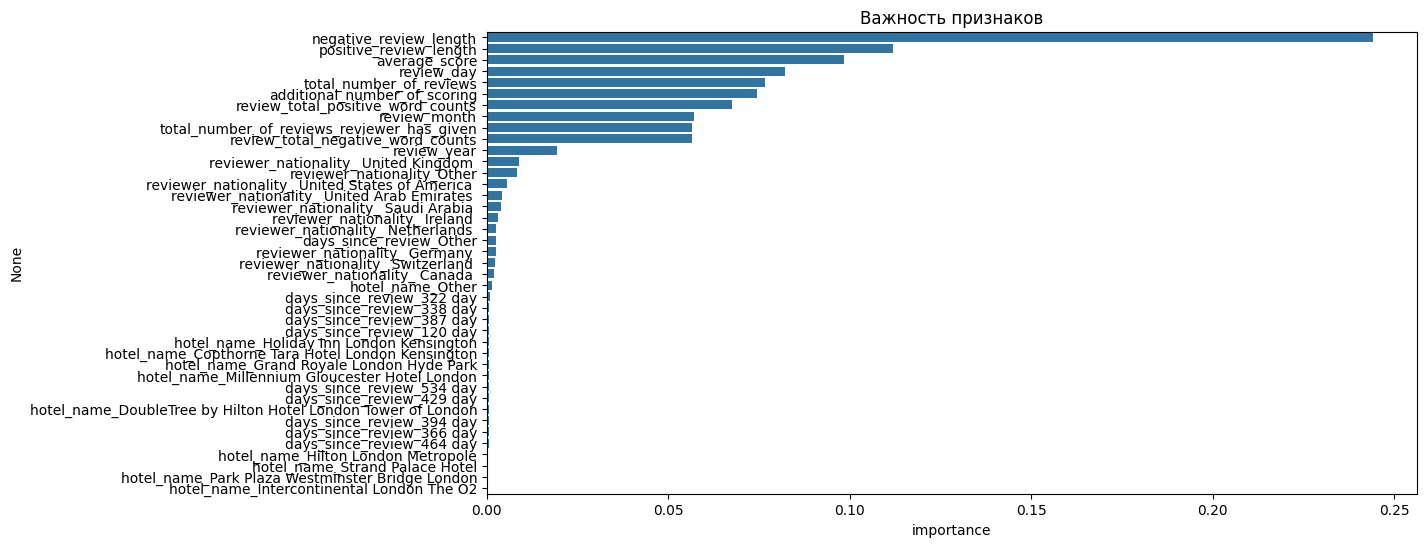

In [ ]:
regr = RandomForestRegressor(n_estimators=100)
regr.fit(X_train, y_train)

# Предсказание значений на тестовом наборе данных
y_pred = regr.predict(X_test)

# Оценка качества модели
mape = metrics.mean_absolute_percentage_error(y_test, y_pred)
print('MAPE:', mape)

# Визуализация важности признаков
feature_importances = pd.DataFrame(regr.feature_importances_,
                                   index=X_train.columns,
                                   columns=['importance']).sort_values('importance', ascending=False)
plt.figure(figsize=(12,6))
sns.barplot(x=feature_importances.importance, y=feature_importances.index)
plt.title('Важность признаков')
plt.show()